# How well is production explained by a small number of factors?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

In [2]:
__context__ = 'local'

import sys

if __context__ == 'local':
    trainDataLocation = '../data/train/'
    libraryLocation = '..'
    from public_timeseries_testing_util import MockApi
    env = MockApi()
    

elif __context__ == 'kaggle':
    trainDataLocation = '/kaggle/input/predict-energy-behavior-of-prosumers/'
    libraryLocation = '/kaggle/input/'
    import enefit
    env = enefit.make_env()

iter_test = env.iter_test()
sys.path.append(libraryLocation)

In [3]:
from enefittools.data import format_dfs

train = pd.read_csv(trainDataLocation+'train.csv')
client = pd.read_csv(trainDataLocation+'client.csv')

weather_forecast = pd.read_csv(trainDataLocation+'forecast_weather.csv')
weather_historical = pd.read_csv(trainDataLocation+'historical_weather.csv')

solar = pd.read_csv(libraryLocation + '/enefittools/data/datasets/solar_data.csv')

train, client, weather_historical, weather_forecast, solar = \
                format_dfs(target=train, client=client, weather_historical=weather_historical,
                           weather_forecast=weather_forecast, solar=solar)


## Random Forest fits

In [4]:
from enefittools.features.random_forest_features import make_features_random_forest

production_train = train.filter( pl.col('is_consumption') == False).drop('is_consumption')

features = make_features_random_forest(production_train, client, weather_forecast, solar)

In [5]:
from enefittools.models import make_wrapped_model
from sklearn.ensemble import RandomForestRegressor

production_model = make_wrapped_model(RandomForestRegressor, max_samples=1000)

production_model.fit(features, production_train)

WrappedModel()

In [6]:
predictions = production_model.predict(features)

In [7]:
predictionData = predictions.group_by(['row_id', 'prediction_unit_id']
                           ).mean(
                           ).join(production_train.drop('date_when_predicting', 'data_block_id'),
                                  on='row_id', suffix='_true'
                           ).with_columns( (pl.col('target_true') - pl.col('target')).alias('error')
                           )

<Axes: xlabel='prediction_datetime'>

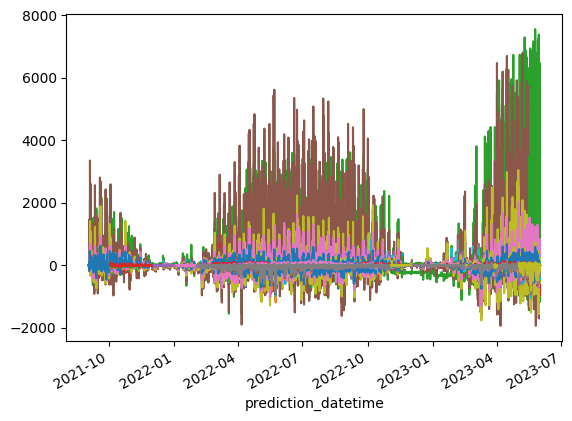

In [8]:
predictionData.to_pandas(
             ).pivot(index='prediction_datetime', columns='prediction_unit_id', values='error'
             ).plot(legend=False)

Wow. These errors get massive?

<Axes: xlabel='prediction_datetime'>

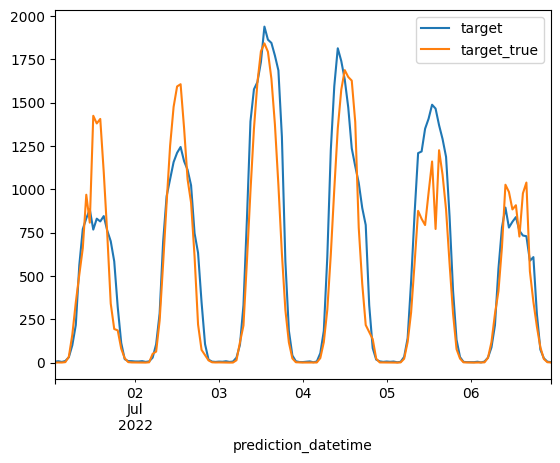

In [9]:
predictionData.filter( (pl.col('prediction_unit_id') == 0) &
                        (pl.col('prediction_datetime') > pd.to_datetime('2022-07-01') ) &
                        (pl.col('prediction_datetime') < pd.to_datetime('2022-07-07') )
             ).select( 'prediction_datetime', 'target', 'target_true'
             ).to_pandas().set_index('prediction_datetime').plot()

Even here, we can be off by thousands. Does increasing the number of trees change things?

It's worth noting the good things about the fit too:
1. day-night cycle is doing well.
2. Even the variation it peak height seems to be well captured.

In [10]:
production_model = make_wrapped_model(RandomForestRegressor, max_samples=10000)
production_model.fit(features, production_train)

WrappedModel()

In [11]:
predictions = production_model.predict(features)

In [12]:
predictionData = predictions.group_by(['row_id', 'prediction_unit_id']
                           ).mean(
                           ).join(production_train.drop('date_when_predicting', 'data_block_id'),
                                  on='row_id', suffix='_true'
                           ).with_columns( (pl.col('target_true') - pl.col('target')).alias('error')
                           )

<Axes: xlabel='prediction_datetime'>

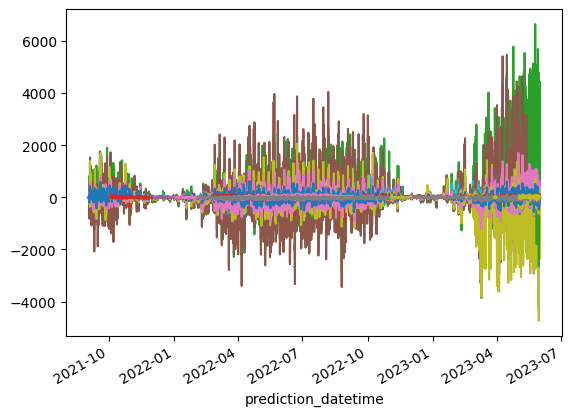

In [13]:
predictionData.to_pandas(
             ).pivot(index='prediction_datetime', columns='prediction_unit_id', values='error'
             ).plot(legend=False)

<Axes: xlabel='prediction_datetime'>

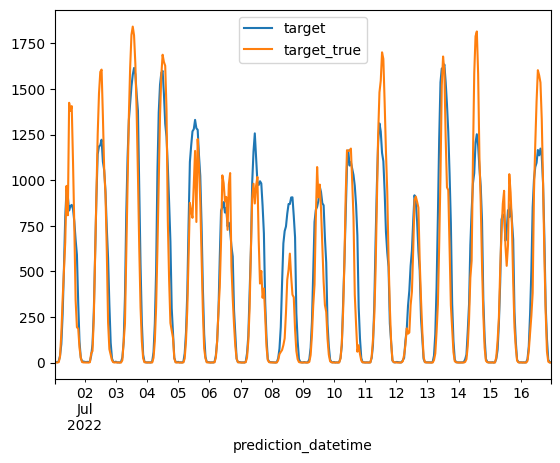

In [14]:
predictionData.filter( (pl.col('prediction_unit_id') == 0) &
                        (pl.col('prediction_datetime') > pd.to_datetime('2022-07-01') ) &
                        (pl.col('prediction_datetime') < pd.to_datetime('2022-07-17') )
             ).select( 'prediction_datetime', 'target', 'target_true'
             ).to_pandas().set_index('prediction_datetime').plot()

More trees seems to be better... It also shows what appears to be some trend, in the green. Also promising.

Note, however, that there is a trend in the errors: they are larger in the summer.


#### Can this be explained by the fact that the errors are multiplicative?

In [15]:
predictionData = predictionData.with_columns( (pl.col('error') / (pl.col('target_true') + 1.) ).alias('fractional_error'))

<Axes: xlabel='prediction_datetime'>

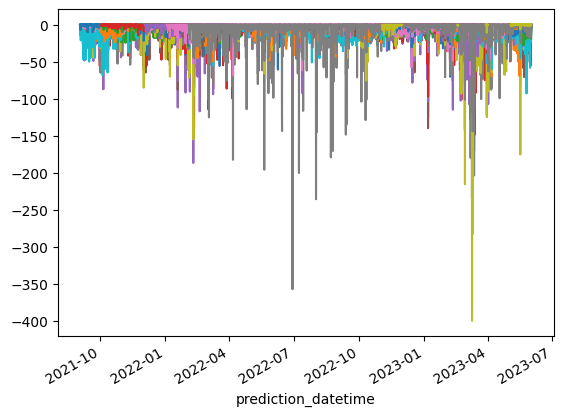

In [16]:
predictionData.to_pandas(
             ).pivot(index='prediction_datetime', columns='prediction_unit_id', values='fractional_error'
             ).plot(legend=False)

Here we use target plus 1 to take care of cases where the target is zero. (Note that this essentially guarantees that positive errors will be less than one.)

This does successfully squish the size of the errors down, and removes much of the periodicity. It also highlights a different type of error: outages in production:

<Axes: xlabel='prediction_datetime'>

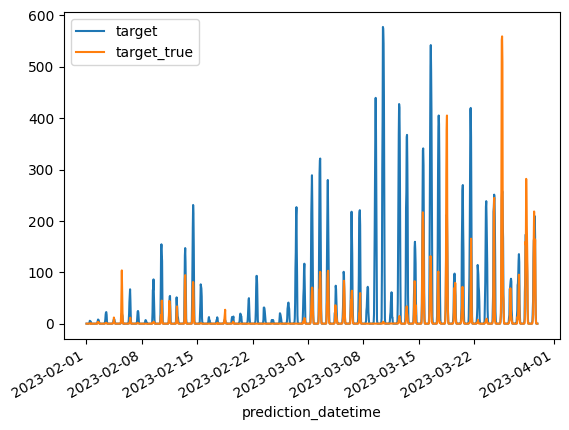

In [17]:
predictionData.filter( (pl.col('prediction_unit_id') == 28) &
                        (pl.col('prediction_datetime') > pd.to_datetime('2023-02-01') ) &
                        (pl.col('prediction_datetime') < pd.to_datetime('2023-03-30') )
             ).select( 'prediction_datetime', 'target', 'target_true'
             ).to_pandas().set_index('prediction_datetime').plot()

### Autocorrelation in the residuals?

This raises the question of whether the underperformance can be explained by auto-correlation in the residuals.
1. This would catch things like outages in a particular system, which can't be explained by other factors.
2. It would also be confounded by autocorrelation in the weather, etc.

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

In [19]:
unitTrajectories = predictionData.select('prediction_unit_id', 'prediction_datetime', 'error'
             ).pivot(index='prediction_datetime', columns='prediction_unit_id', values='error')

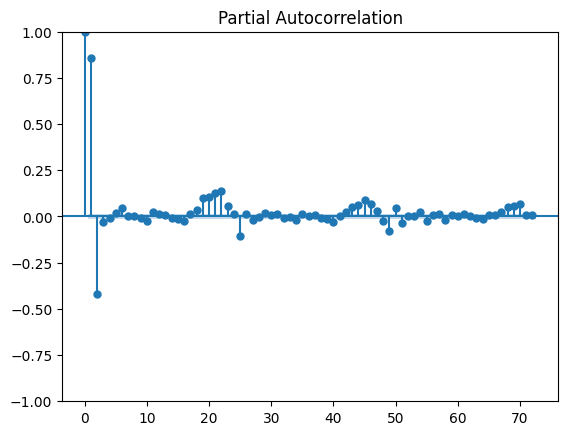

In [20]:
_ =plot_pacf(unitTrajectories['0'], lags=72 )

Ok, nice. There is certainly some autocorrelation in the residuals. In particular around 0, 24, 48, 72 hours.

In this problem, we receive data for a span of two days every 48 hours. Thus, for the first point in the interval, we have data all data before _25 hours_ ago, while the last point in the interval sees all data before _48 hours ago_
- due to the availability of more recent data, it is reasonable to think that earlier predictions might help improve later predictions.

## Multiplicative Linear Regression fits

In [46]:
from enefittools.features.regression_features import make_date_process, make_regression_features

dates = make_date_process(train)

train = train.filter( pl.col('is_consumption') == False)
features = make_regression_features(train, client, dates)

In [22]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from enefittools.models import make_wrapped_model

M = make_wrapped_model( TransformedTargetRegressor, regressor=LinearRegression(), 
                        func=np.log1p, inverse_func=np.expm1)

In [23]:
M.fit(features, train)


WrappedModel()

<Axes: xlabel='target_true', ylabel='target'>

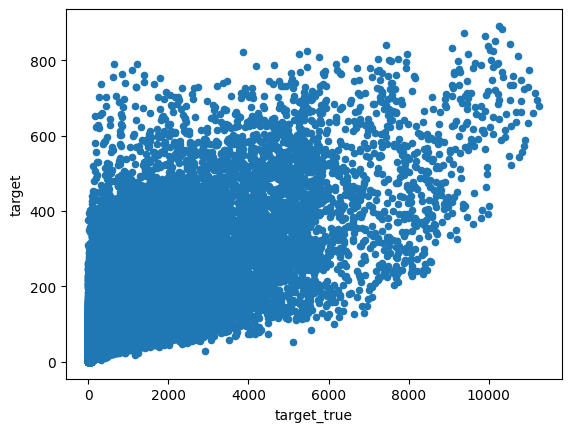

In [24]:
M.predict(features
).join(train[['row_id', 'target']], on='row_id', suffix='_true' 
).to_pandas().plot.scatter(x='target_true', y='target')

The multiplicative linear model works very very poorly. Like, off by a factor of 10 poorly. How is that possible?

<Axes: xlabel='target_true', ylabel='target'>

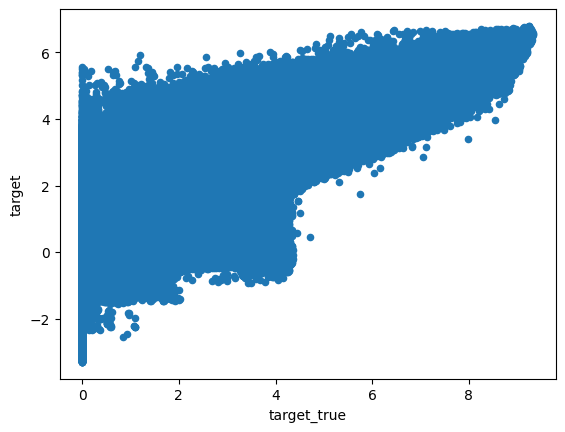

In [25]:
M.predict(features
).join(train[['row_id', 'target']], on='row_id', suffix='_true'
).with_columns(
    np.log1p(pl.col('target')),
    np.log1p(pl.col('target_true'))
).to_pandas().plot.scatter(x='target_true', y='target')

It looks at least linear in the log space. It's still surprisingly poor through.

#### Time-dependence of prediction errors

<Axes: xlabel='prediction_datetime'>

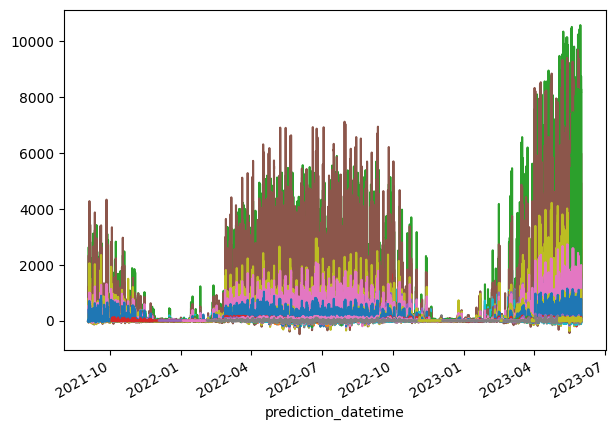

In [26]:
figsize(7,5)
M.predict(features
).join(train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true' 
).with_columns( (pl.col('target_true') - pl.col('target') ).alias('error')
).to_pandas().pivot(index='prediction_datetime', columns='prediction_unit_id',
                    values='error'
).plot(legend=False)


This plot looks very similar to the version for random forests above (albeit with errors that are more positive and less negative. However, in this case, the model without a doubt is multiplicative, so that is _not_ the casuse of the poor fits.

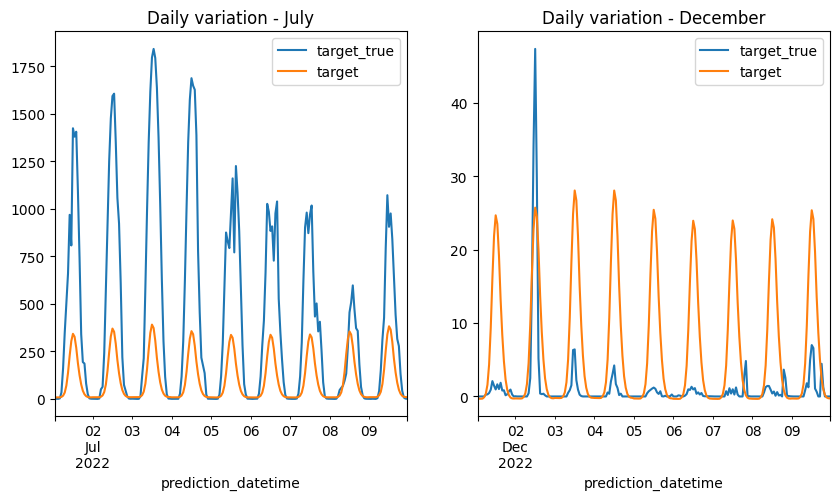

In [27]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Daily variation - July')
M.predict(features
).join(train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true' 
).filter(
     (pl.col('prediction_unit_id') == 0) &
     (pl.col('prediction_datetime') > pd.to_datetime('2022-07-01') ) &
     (pl.col('prediction_datetime') < pd.to_datetime('2022-07-10') )
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[0])

_=axes[1].set_title('Daily variation - December')
_=M.predict(features
).join(train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true' 
).filter(
     (pl.col('prediction_unit_id') == 0) &
     (pl.col('prediction_datetime') > pd.to_datetime('2022-12-01') ) &
     (pl.col('prediction_datetime') < pd.to_datetime('2022-12-10') )
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[1])

This highlights the model is not fitting strongly enough on the interaction between season and time of day.

<Axes: xlabel='prediction_datetime'>

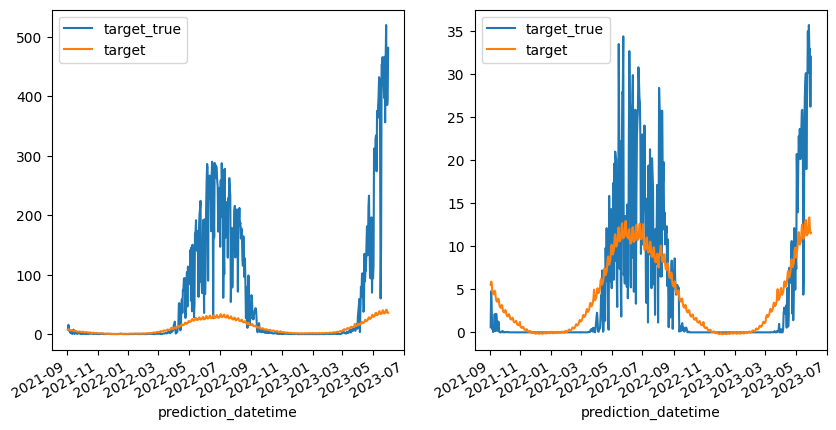

In [28]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)

M.predict(features
).join(train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true' 
).group_by( pl.col('prediction_unit_id'), pl.col('prediction_datetime').dt.date() 
).agg( pl.col('target').median(), pl.col('target_true').median() 
).filter( (pl.col('prediction_unit_id') == 0)
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[0])


M.predict(features
).join(train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true' 
).group_by( pl.col('prediction_unit_id'), pl.col('prediction_datetime').dt.date() 
).agg( pl.col('target').median(), pl.col('target_true').median() 
).filter( (pl.col('prediction_unit_id') == 55)
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[1])

There is also mismatch at the level of daily median values. Some of this may be caused by heterogenity among prediction units?

<Axes: xlabel='prediction_datetime'>

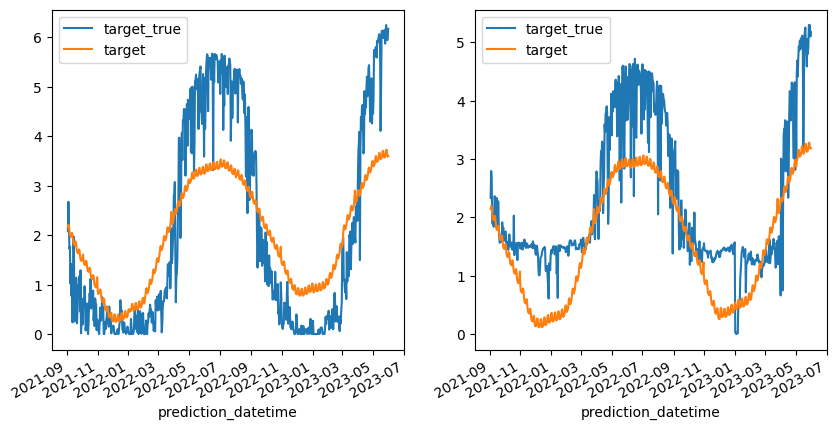

In [29]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)

M.predict(features
).join(train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true' 
).with_columns( np.log1p( pl.col('target')), np.log1p( pl.col('target_true'))
).group_by( pl.col('prediction_unit_id'), pl.col('prediction_datetime').dt.date() 
).agg( pl.col('target').median(), pl.col('target_true').median() 
).filter( (pl.col('prediction_unit_id') == 0)
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[0])


M.predict(features
).join(train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true' 
).with_columns( np.log1p( pl.col('target')), np.log1p( pl.col('target_true'))
).group_by( pl.col('prediction_unit_id'), pl.col('prediction_datetime').dt.date() 
).agg( pl.col('target').median(), pl.col('target_true').median() 
).filter( (pl.col('prediction_unit_id') == 58)
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[1])

Even in log space, the fits are woeful.

### Is it the effect of multiple prediction units?

In [30]:
sub_feat = features.filter( pl.col('prediction_unit_id') == 0)
sub_train = train.filter( pl.col('prediction_unit_id') == 0)

sub_model = make_wrapped_model( TransformedTargetRegressor, 
                               regressor=LinearRegression(), 
                                func=np.log1p, inverse_func=np.expm1)

In [31]:
sub_model = sub_model.fit(sub_feat, sub_train)

<Axes: xlabel='target_true', ylabel='target'>

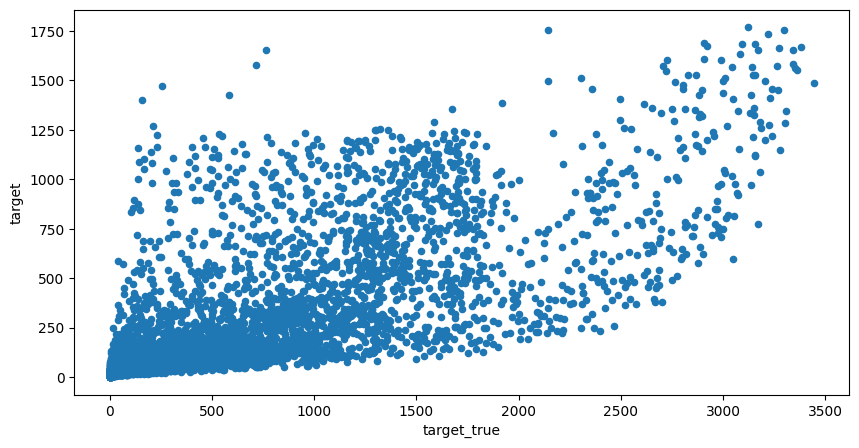

In [32]:
sub_model.predict(sub_feat
).join(sub_train[['row_id', 'target']], on='row_id', suffix='_true'
).with_columns(

).to_pandas().plot.scatter(x='target_true', y='target')

It still fails: so heterogenity does not explain the shittiness. Maybe the issue is simply the large number of very small targets dominating the linear fit?

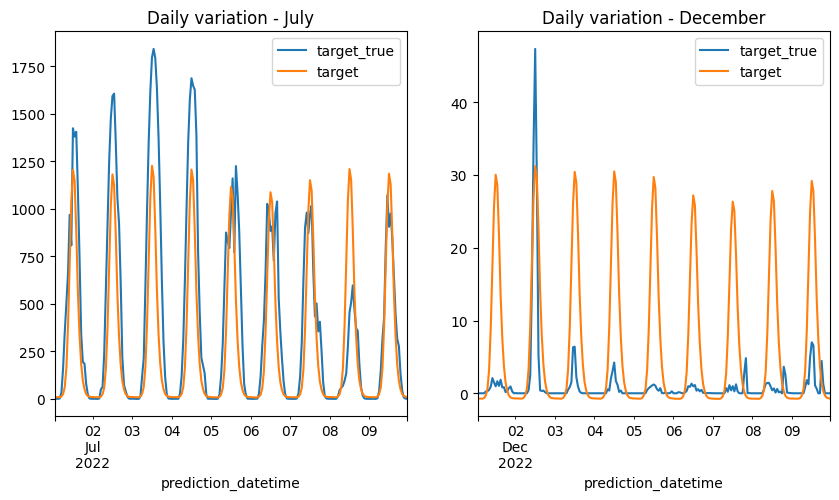

In [33]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Daily variation - July')
sub_model.predict(sub_feat
).join(sub_train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true'
).filter(
     (pl.col('prediction_datetime') > pd.to_datetime('2022-07-01') ) &
     (pl.col('prediction_datetime') < pd.to_datetime('2022-07-10') )
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[0])

_=axes[1].set_title('Daily variation - December')
_=sub_model.predict(sub_feat
).join(sub_train[['row_id', 'target', 'prediction_datetime']], on='row_id', suffix='_true'
).filter(
     (pl.col('prediction_datetime') > pd.to_datetime('2022-12-01') ) &
     (pl.col('prediction_datetime') < pd.to_datetime('2022-12-10') )
).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[1])


### Some Conclusions:

1. The multiplicative error alone is _not_ the source of poor fits, since the multiplicative model fits those too.
2. Heterogenity among prediction units is also not the cause of fitting failures, since they remain for models fit to 




### How much does the variation level differ between different production units and different times?

<Axes: xlabel='daily_mean', ylabel='daily_std'>

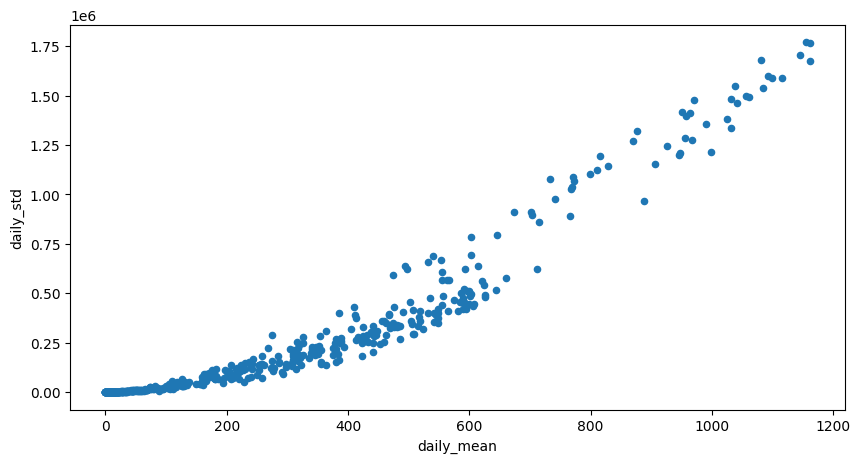

In [89]:
train.filter(pl.col('prediction_unit_id') == 0
    ).group_by(pl.col('prediction_datetime').dt.date().alias('date')
    ).agg(pl.col('target').mean().alias('daily_mean'),
          pl.col('target').var().alias('daily_std')
    ).to_pandas().plot.scatter(x='daily_mean', y='daily_std')

Looking across times, the relationship between daily average and standared deviation is not linear.

Text(0.5, 1.0, 'Accounting for changes in EIC count')

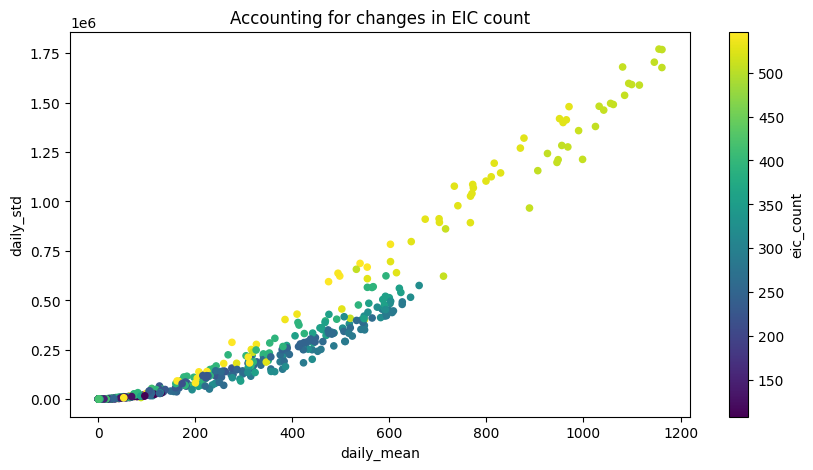

In [161]:
client = pd.read_csv(trainDataLocation+'client.csv')
client = format_dfs(client=client)[0]

eic_impact = train.filter(pl.col('prediction_unit_id') == 0
                 ).join(client, 
                        left_on=['county', 'is_business', 'product_type', pl.col('prediction_datetime').dt.date()],
                        right_on=['county', 'is_business', 'product_type', 'date'],
                        how='inner'
                       )
eic_impact.group_by(pl.col('prediction_datetime').dt.date().alias('date')
    ).agg(pl.col('target').mean().alias('daily_mean'),
          pl.col('target').var().alias('daily_std'),
          pl.col('eic_count').median()
    ).to_pandas().plot.scatter(x='daily_mean', y='daily_std', c='eic_count', colormap='viridis')

plt.title('Accounting for changes in EIC count')

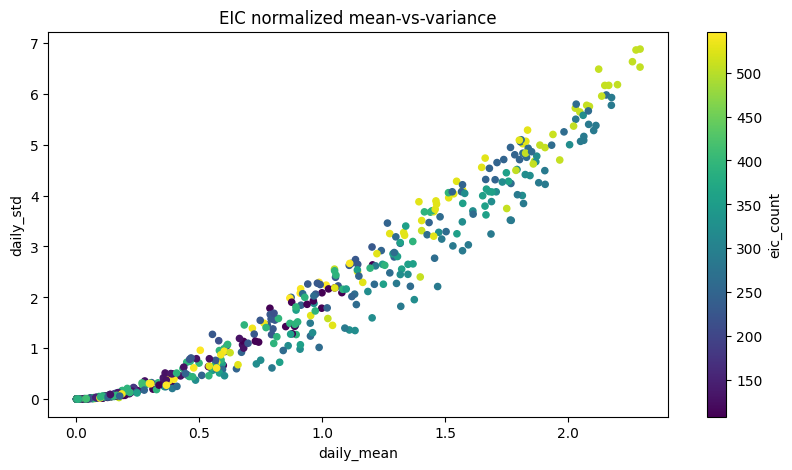

In [162]:
eic_impact.with_columns(pl.col('target') / pl.col('eic_count')
         ).group_by(pl.col('prediction_datetime').dt.date().alias('date')
        ).agg(pl.col('target').mean().alias('daily_mean'),
              pl.col('target').var().alias('daily_std'),
              pl.col('eic_count').median()
        ).to_pandas().plot.scatter(x='daily_mean', y='daily_std', c='eic_count', colormap='viridis')

_=plt.title('EIC normalized mean-vs-variance')

Normalizing to EIC count does a good job of tightening up the mean-variance relationship. However, I still wonder about the lower end of the curve.

<Axes: xlabel='daily_mean', ylabel='daily_std'>

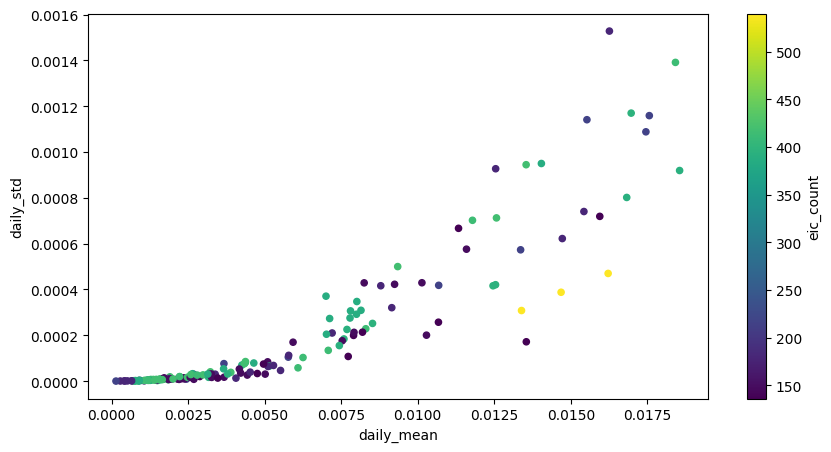

In [169]:
eic_impact.with_columns(pl.col('target') / pl.col('eic_count')
         ).group_by(pl.col('prediction_datetime').dt.date().alias('date')
        ).agg(pl.col('target').mean().alias('daily_mean'),
              pl.col('target').var().alias('daily_std'),
              pl.col('eic_count').median()
        ).filter(
            pl.col('daily_mean') < 0.02
        ).to_pandas().plot.scatter(x='daily_mean', y='daily_std', c='eic_count', colormap='viridis')

Does this 'tail' dominate the predictions?

#### Comparing daily means to medians shows an interesting effect.

<Axes: xlabel='daily_mean', ylabel='daily_median'>

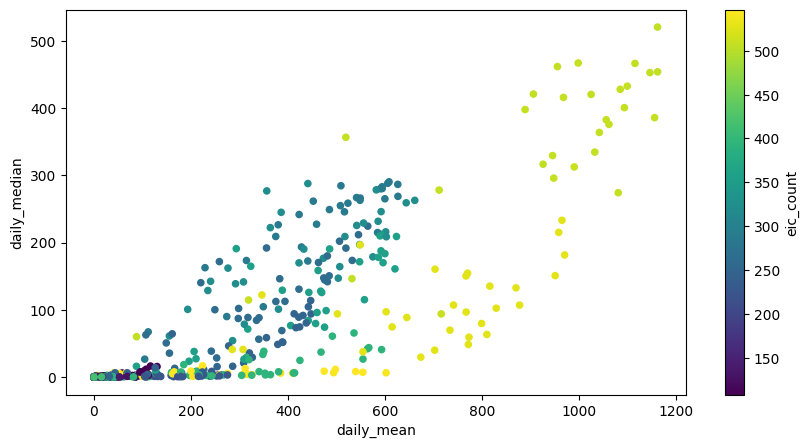

In [164]:
eic_impact.group_by(pl.col('prediction_datetime').dt.date().alias('date')
    ).agg(pl.col('target').mean().alias('daily_mean'),
          pl.col('target').median().alias('daily_median'),
          pl.col('eic_count').median()
    ).to_pandas().plot.scatter(x='daily_mean', y='daily_median', c='eic_count', colormap='viridis')


<Axes: xlabel='date'>

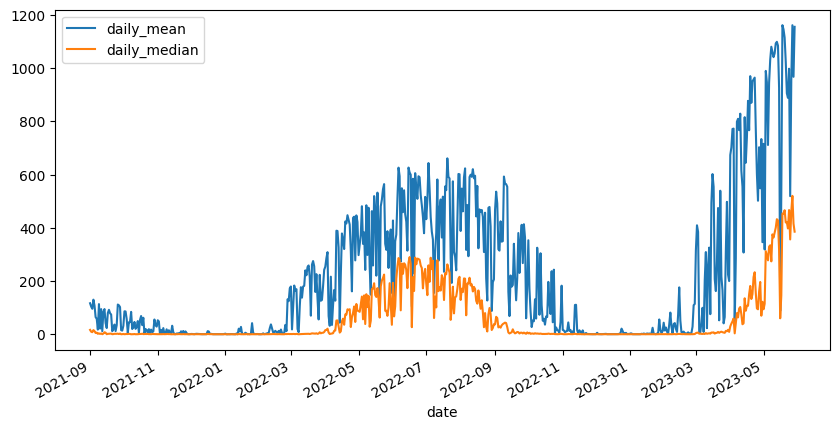

In [166]:
eic_impact.group_by(pl.col('prediction_datetime').dt.date().alias('date')
    ).agg(pl.col('target').mean().alias('daily_mean'),
          pl.col('target').median().alias('daily_median'),
          pl.col('eic_count').median()
    ).to_pandas().plot(x='date', y=['daily_mean', 'daily_median'])

The big difference between the daily median and daily mean seems to indicate that, on days with high production, most of the production comes from a small numbers of hours.

This is another feature of the log-normal distribution.

#### Fitting with only large values

In [235]:
large_features = features.filter( pl.col('prediction_unit_id') == 0)
large_train = train.filter( (pl.col('prediction_unit_id') == 0) & (pl.col('target') > 10) )


large_model = make_wrapped_model( TransformedTargetRegressor, 
                               regressor=LinearRegression(), 
                                func=np.log1p, inverse_func=np.expm1)

In [236]:
large_model.fit(large_features, large_train)

WrappedModel()

<Axes: xlabel='target_true', ylabel='target'>

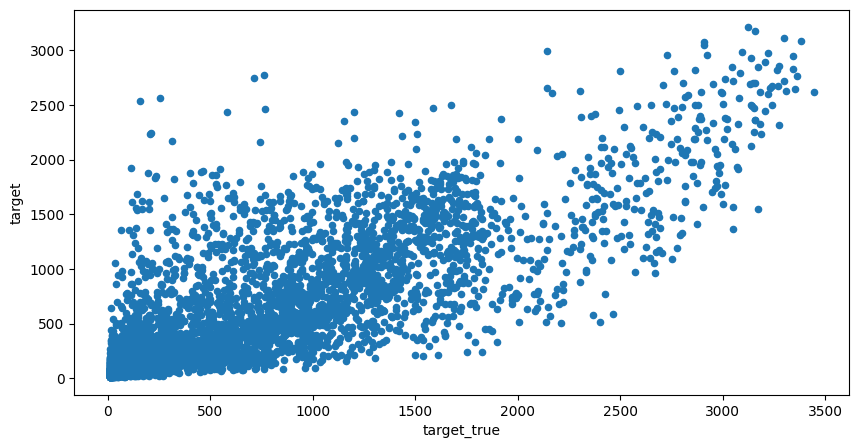

In [237]:
large_model.predict(large_features
          ).join(large_train, on='row_id', how='inner', suffix='_true'
          ).to_pandas().plot.scatter(x='target_true', y='target')

This is already an improvement.

### Minimal model with solar features

In [94]:
def make_features_minimal(train, client, solar):
    features = train.with_columns( pl.col('prediction_datetime').dt.date().alias('date')
               ).join(client,
                      on= ['county', 'is_business', 'product_type', 'date'],
                      how='inner'
               ).join(solar, left_on='prediction_datetime', right_on='datetime')
    target = features.select(['prediction_unit_id', 'row_id', 'target'])
    features = features.with_columns( 
                            np.log1p(pl.col('installed_capacity')),
                            #(pl.col('solar_elevation') < 0.).alias('night')
                      ).select(['prediction_unit_id', 'row_id', 'installed_capacity', 'eic_count',
                                'solar_azimuth', 'solar_elevation'
                               ])
    return features, target

In [95]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from enefittools.models import make_wrapped_model

minimal_features, minimal_targets=make_features_minimal(train, client, solar)
minimal_model =  make_wrapped_model( TransformedTargetRegressor, 
                               regressor=LinearRegression(fit_intercept=False), 
                                func=np.log1p, inverse_func=np.expm1)

In [96]:
minimal_model.fit(minimal_features, minimal_targets)

WrappedModel()

<Axes: xlabel='target_true', ylabel='target'>

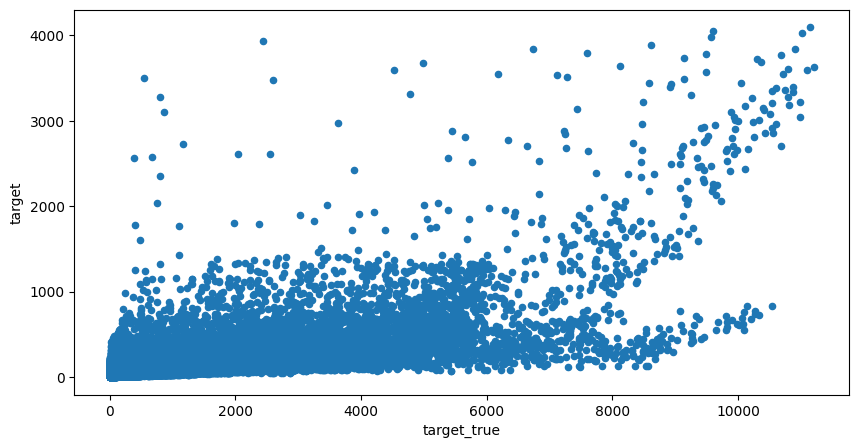

In [97]:
minimal_model.predict( minimal_features
            ).join( minimal_targets, on='row_id', suffix='_true'
            ).to_pandas().plot.scatter(x='target_true', y='target')

<Axes: title={'center': 'Daily variation - December'}, xlabel='prediction_datetime'>

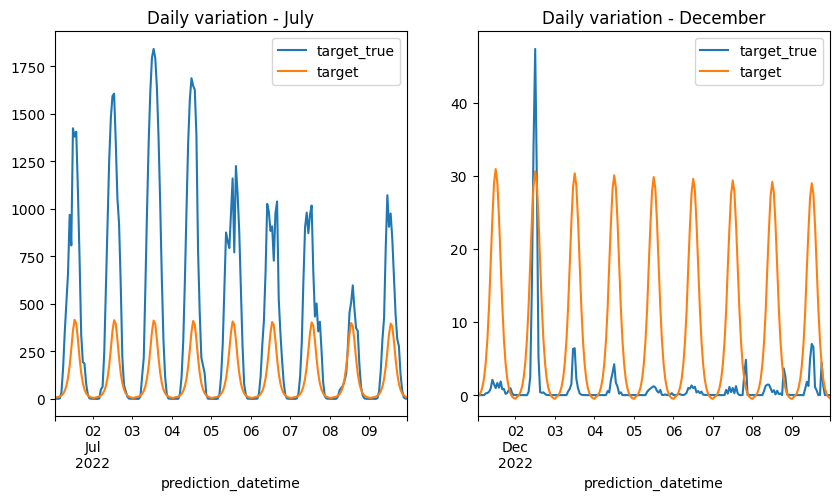

In [98]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Daily variation - July')
minimal_model.predict( minimal_features
            ).join( train, on='row_id', suffix='_true'
            ).filter(
                (pl.col('prediction_unit_id') == 0) &
                 (pl.col('prediction_datetime') > pd.to_datetime('2022-07-01') ) &
                 (pl.col('prediction_datetime') < pd.to_datetime('2022-07-10') )
            ).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[0])

_=axes[1].set_title('Daily variation - December')
minimal_model.predict( minimal_features
            ).join( train, on='row_id', suffix='_true'
            ).filter(
                (pl.col('prediction_unit_id') == 0) &
                 (pl.col('prediction_datetime') > pd.to_datetime('2022-12-01') ) &
                 (pl.col('prediction_datetime') < pd.to_datetime('2022-12-10') )
            ).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[1])

#### As bad as this fit is, it's still better

This highlights a key problem with the linear model: I'm trying to use one basis function (i.e. solar elevation) to fit both the daytime production output, and also push the night-time output to zero. 

I think that this is why cutting the smaller production outputs is helpful: it essentially frees the solar elevation up to fit the peak oscillations.

Essentially, the problem is that, the size of coefficient required to effectively push examples to zero depends on all of the other coefficients that we are fitting. 

Note that this effect can get _worse_ with more covariates, if the model fits their effect based on small variations during nighttime.

### Auto-regressive features

This seems to be a potential source of massive improvement. I'm a little worried about fitting autocorrelations in the weather, but that might be overthinking.

In [156]:
def make_features_AR(train, client, solar):
    train = train.with_columns(
                (pl.col('prediction_datetime') - datetime.timedelta(days=2)).alias('prev_point')
            ).join( train[['target', 'prediction_datetime', 'prediction_unit_id']], 
                   left_on=['prediction_unit_id', 'prev_point'],
                   right_on=['prediction_unit_id', 'prediction_datetime'],
                   how='inner',
                   suffix='_previous'
                  )
    features = train.with_columns( pl.col('prediction_datetime').dt.date().alias('date')
               ).join(client,
                      on= ['county', 'is_business', 'product_type', 'date'],
                      how='inner'
               ).join(solar, left_on='prediction_datetime', right_on='datetime')
    target = features.select(['prediction_unit_id', 'row_id', 'target'])
    features = features.with_columns( 
                            np.log1p(pl.col('installed_capacity')),
                            np.log1p(pl.col('target_previous'))
                            #(pl.col('solar_elevation') < 0.).alias('night')
                      ).select(['prediction_unit_id', 'row_id', 'installed_capacity', 'eic_count',
                                'solar_azimuth', 'solar_elevation', 'target_previous'
                               ])
    return features, target

In [157]:
AR_features, AR_targets=make_features_AR(train, client, solar)
AR_model =  make_wrapped_model( TransformedTargetRegressor, 
                               regressor=LinearRegression(fit_intercept=False), 
                                func=np.log1p, inverse_func=np.expm1)

In [158]:
AR_model.fit(AR_features, AR_targets)

WrappedModel()

<Axes: xlabel='target_true', ylabel='target'>

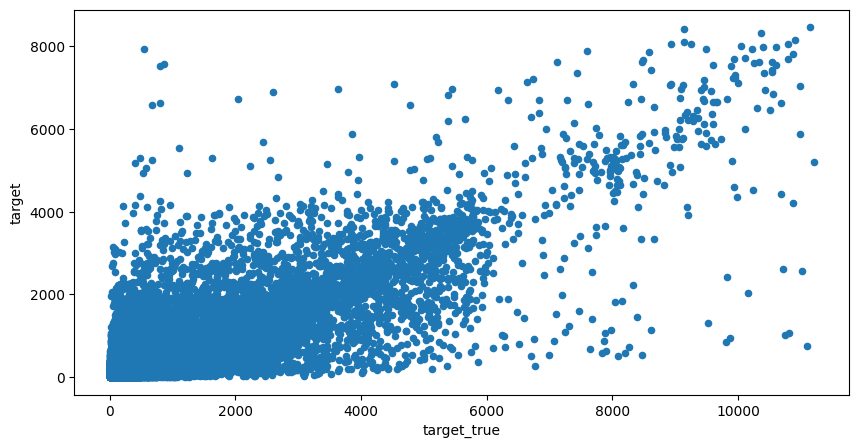

In [160]:
AR_model.predict( AR_features
            ).join( AR_targets, on='row_id', suffix='_true'
            ).to_pandas().plot.scatter(x='target_true', y='target')

<Axes: title={'center': 'Daily variation - December'}, xlabel='prediction_datetime'>

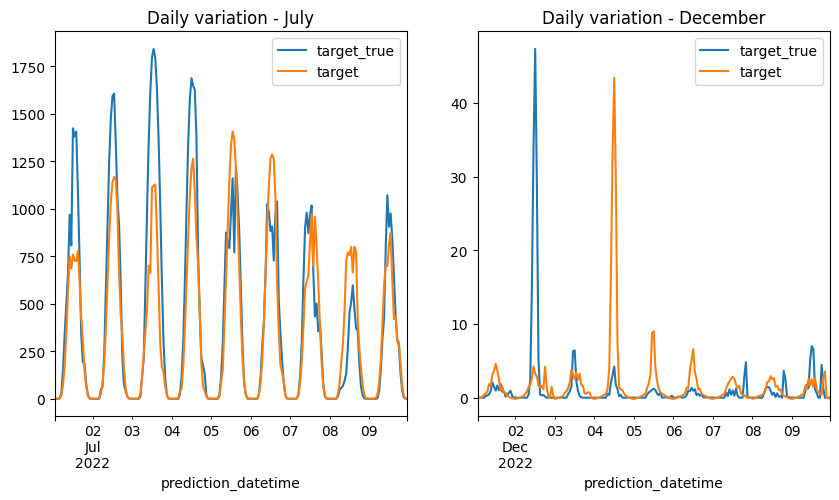

In [162]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Daily variation - July')
AR_model.predict( AR_features
            ).join( train, on='row_id', suffix='_true'
            ).filter(
                (pl.col('prediction_unit_id') == 0) &
                 (pl.col('prediction_datetime') > pd.to_datetime('2022-07-01') ) &
                 (pl.col('prediction_datetime') < pd.to_datetime('2022-07-10') )
            ).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[0])

_=axes[1].set_title('Daily variation - December')
AR_model.predict( AR_features
            ).join( train, on='row_id', suffix='_true'
            ).filter(
                (pl.col('prediction_unit_id') == 0) &
                 (pl.col('prediction_datetime') > pd.to_datetime('2022-12-01') ) &
                 (pl.col('prediction_datetime') < pd.to_datetime('2022-12-10') )
            ).to_pandas().plot(x='prediction_datetime', y=['target_true','target'], ax=axes[1])

As expected, the AR features do greatly improve the fits. At the moment, I'm still inclined to introduce these features later. At the moment, the model is over-reliant on these features, and I think that there are many improvements to be made in the seasonal (and weather) modelling before using the AR feaures.

In [163]:
AR_model.feature_names_in_

array(['installed_capacity', 'eic_count', 'solar_azimuth',
       'solar_elevation', 'target_previous'], dtype=object)

In [164]:
AR_model.regressor_.coef_

array([ 6.41271682e-02,  2.37013681e-04, -2.03754434e-04,  1.37066097e-02,
        7.92311526e-01])